In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly.plotly as py 
import plotly.graph_objs as go #importing graphical objects
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
#Reading the csv file
#df=pd.read_csv('solar.csv',sep=';')
#df.drop('State',inplace=True,axis=1)

In [3]:
#Columns of DataFrame
#print(df.columns)

In [4]:
### Utility Functions
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [5]:
# Delete old database file

normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename, delete_db=True)

In [6]:
ll=[]
def step1_create_project_table(data_filename, normalized_database_filename):
    with open(data_filename) as file:
        c=0
        l1=[]
        lis=[]
        l2=[]
        for row in file:
            if c==0:
                c+=1
                continue
            row = row.strip("\n")
            l=row.split(';')
            if c%2!=0:
                ll.append((l[1],l[6],l[7],l[8],l[9],l[10],l[13],l[14]))
            c+=1
        c=1
        lis=[]
        for ele in sorted(ll):
            lis.append(ele)
        #lis.sort(key=lambda x:x[1]+x[2])
        conn_norm=create_connection(normalized_database_filename)
        create_table(conn_norm,"create table Project(ProjectID TEXT NOT NULL PRIMARY KEY,Sector TEXT, Program Type TEXT, Solicitation TEXT, Electric Utility TEXT, Purchase Type TEXT, Project Status TEXT,Contractor TEXT,UNIQUE(ProjectID))","Project")
        conn_norm.commit()
        cur = conn_norm.cursor()
        cur.executemany("INSERT INTO Project VALUES (?, ?, ?, ?, ?, ?, ?, ?)", lis)
        conn_norm.commit()

In [7]:
#Verifying the table creation & insertion of Project
normalized_database_filename = 'normalized.db'
data_filename = 'solar.csv'
step1_create_project_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM Project""", conn)
print(df.head())

   ProjectID Sector          Program                         Solicitation  \
0  0107456-1  13660  Non-Residential  Commercial/Industrial (Competitive)   
1  028807A-1  11215  Non-Residential  Commercial/Industrial (Competitive)   
2  031335A-1  12550  Non-Residential  Commercial/Industrial (Competitive)   
3  033492A-1  13053  Non-Residential  Commercial/Industrial (Competitive)   
4       1000  11205      Residential         Residential/Small Commercial   

    Electric                         Purchase     Project Contractor  
0   PON 2956                    National Grid  09/27/2017   Complete  
1   PON 2484              Consolidated Edison  12/20/2013   Complete  
2  PON 2589B  Central Hudson Gas and Electric  12/03/2013   Complete  
3  PON 2589B             NYS Electric and Gas  06/17/2015   Complete  
4    PON 716              Consolidated Edison  10/29/2007   Complete  


In [8]:
ll=[]
def step2_create_project_location_table(data_filename, normalized_database_filename):
    with open(data_filename) as file:
        c=0
        k=1
        l1=[]
        lis=[]
        l2=[]
        for row in file:
            if c==0:
                c+=1
                continue
            row = row.strip("\n")
            l=row.split(';')
            if c%2!=0:
                l[30]=l[30].strip('"')
                ll.append((k,l[6],l[1],l[3],l[4]))
                k+=1
            c+=1
        c=1
        lis=[]
        for ele in ll:
            lis.append(ele)
            if c<10:
                print(ele)
            c+=1
        #lis.sort(key=lambda x:x[1]+x[2])
        conn_norm=create_connection(normalized_database_filename)
        create_table(conn_norm,"create table ProjectLocation(ProjectLocationID INTEGER NOT NULL PRIMARY KEY, ZipCode TEXT NOT NULL, ProjectID TEXT NOT NULL,City TEXT,County TEXT, FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(ProjectLocationID))","ProjectLocation")
        conn_norm.commit()
        cur = conn_norm.cursor()
        cur.executemany("INSERT INTO ProjectLocation VALUES (?, ?, ?, ?, ?)", lis)
        conn_norm.commit()

In [9]:
#Verifying the table creation & insertion of ProjectLocation
normalized_database_filename = 'normalized.db'
data_filename = 'solar.csv'
step2_create_project_location_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectLocation""", conn)
print(df.head())

(1, '11763', '2011-189637-SLPR', 'Medford', 'Suffolk')
(2, '11933', '2013-530718-Sola', 'Calverton', 'Suffolk')
(3, '11788', '2014-646148-Sola', 'Hauppauge', 'Suffolk')
(4, '12866', '31307-1', 'Saratoga Springs', 'Saratoga')
(5, '14886', '431', 'Trumansburg', 'Tompkins')
(6, '12054', '793', 'Delmar', 'Albany')
(7, '14727', '1182', 'Cuba', 'Allegany')
(8, '10580', '1224', 'Rye', 'Westchester')
(9, '14420', '1727', 'Brockport', 'Monroe')
   ProjectLocationID ZipCode         ProjectID              City    County
0                  1   11763  2011-189637-SLPR           Medford   Suffolk
1                  2   11933  2013-530718-Sola         Calverton   Suffolk
2                  3   11788  2014-646148-Sola         Hauppauge   Suffolk
3                  4   12866           31307-1  Saratoga Springs  Saratoga
4                  5   14886               431       Trumansburg  Tompkins


In [10]:
ll=[]
def step3_create_inverter_details_table(data_filename, normalized_database_filename):
    with open(data_filename) as file:
        c=0
        k=1
        l1=[]
        lis=[]
        l2=[]
        for row in file:
            if c==0:
                c+=1
                continue
            row = row.strip("\n")
            l=row.split(';')
            if c%2!=0:
                l[30]=l[30].strip('"')
                ll.append((k,l[1],l[16],l[17],l[18]))
                k+=1
            c+=1
        c=1
        lis=[]
        for ele in ll:
            lis.append(ele)
        conn_norm=create_connection(normalized_database_filename)
        create_table(conn_norm,"create table InverterDetails(InverterDetailsID INTEGER NOT NULL PRIMARY KEY, ProjectID TEXT NOT NULL, PriInvetMft TEXT, PriInvetModNo TEXT,TotalInvtQt TEXT, FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(InverterDetailsID))","InverterDetails")
        conn_norm.commit()
        cur = conn_norm.cursor()
        cur.executemany("INSERT INTO InverterDetails VALUES (?, ?, ?, ?, ?)", lis)
        conn_norm.commit()

In [11]:
#Verifying the table creation & insertion of InverterDetails
normalized_database_filename = 'normalized.db'
data_filename = 'solar.csv'
step3_create_inverter_details_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM InverterDetails""", conn)
print(df.head())

   InverterDetailsID         ProjectID  PriInvetMft PriInvetModNo TotalInvtQt
0                  1  2011-189637-SLPR                                      0
1                  2  2013-530718-Sola    Power-One                         2
2                  3  2014-646148-Sola    SolarEdge                         1
3                  4           31307-1                                       
4                  5               431  Fronius USA       IG 2000           1


In [12]:
ll=[]
def step4_create_pvmodule_details_table(data_filename, normalized_database_filename):
    with open(data_filename) as file:
        c=0
        k=1
        l1=[]
        lis=[]
        l2=[]
        for row in file:
            if c==0:
                c+=1
                continue
            row = row.strip("\n")
            l=row.split(';')
            if c%2!=0:
                l[30]=l[30].strip('"')
                ll.append((k,l[1],l[16],l[17],l[18]))
                k+=1
            c+=1
        c=1
        lis=[]
        for ele in ll:
            lis.append(ele)
        conn_norm=create_connection(normalized_database_filename)
        create_table(conn_norm,"create table PVModuleDetails(PVModuleDetailsID INTEGER NOT NULL PRIMARY KEY, ProjectID TEXT NOT NULL, PriPVMft TEXT, PriPVModNo TEXT,TotalPVQt TEXT, FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(PVModuleDetailsID))","PVModuleDetails")
        conn_norm.commit()
        cur = conn_norm.cursor()
        cur.executemany("INSERT INTO PVModuleDetails VALUES (?, ?, ?, ?, ?)", lis)
        conn_norm.commit()

In [13]:
#Verifying the table creation & insertion of PVModuleDetails
normalized_database_filename = 'normalized.db'
data_filename = 'solar.csv'
step4_create_pvmodule_details_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM PVModuleDetails""", conn)
print(df.head())

   PVModuleDetailsID         ProjectID     PriPVMft PriPVModNo TotalPVQt
0                  1  2011-189637-SLPR                                 0
1                  2  2013-530718-Sola    Power-One                    2
2                  3  2014-646148-Sola    SolarEdge                    1
3                  4           31307-1                                  
4                  5               431  Fronius USA    IG 2000         1


In [14]:
ll=[]
def step5_create_project_timeline_table(data_filename, normalized_database_filename):
    with open(data_filename) as file:
        c=0
        k=1
        l1=[]
        lis=[]
        l2=[]
        for row in file:
            if c==0:
                c+=1
                continue
            row = row.strip("\n")
            l=row.split(';')
            if c%2!=0:
                l[30]=l[30].strip('"')
                ll.append((k,l[1],l[11],l[12]))
                k+=1
            c+=1
        c=1
        lis=[]
        for ele in ll:
            lis.append(ele)
        conn_norm=create_connection(normalized_database_filename)
        create_table(conn_norm,"""create table ProjectTimeline(ProjectTimelineID INTEGER NOT NULL PRIMARY KEY, ProjectID 
        TEXT NOT NULL, DtAppReceived TEXT, DtCompleted TEXT,
        FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(ProjectTimelineID))""","ProjectTimeline")
        conn_norm.commit()
        cur = conn_norm.cursor()
        cur.executemany("INSERT INTO ProjectTimeline VALUES (?, ?, ?, ?)", lis)
        conn_norm.commit()

In [15]:
#Verifying the table creation & insertion of ProjectTimeline
normalized_database_filename = 'normalized.db'
data_filename = 'solar.csv'
step5_create_project_timeline_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectTimeline""", conn)
print(df.head())

   ProjectTimelineID         ProjectID DtAppReceived DtCompleted
0                  1  2011-189637-SLPR      Purchase  10/02/2008
1                  2  2013-530718-Sola      Purchase  03/01/2013
2                  3  2014-646148-Sola      Purchase  04/03/2014
3                  4           31307-1      Purchase  02/22/2013
4                  5               431                10/30/2007


In [16]:
ll=[]
def step6_create_project_cost_table(data_filename, normalized_database_filename):
    with open(data_filename) as file:
        c=0
        k=1
        l1=[]
        lis=[]
        l2=[]
        for row in file:
            if c==0:
                c+=1
                continue
            row = row.strip("\n")
            l=row.split(';')
            if c%2!=0:
                l[30]=l[30].strip('"')
                ll.append((k,l[1],l[22],l[23],l[26],l[27],l[29]))
                k+=1
            c+=1
        c=1
        lis=[]
        for ele in ll:
            lis.append(ele)
        conn_norm=create_connection(normalized_database_filename)
        create_table(conn_norm,"""create table ProjectCost(ProjectCostID INTEGER NOT NULL PRIMARY KEY, ProjectID 
        TEXT NOT NULL, ProjectCost TEXT, Incentive TEXT, RemNetMet TEXT, AffSolar TEXT, GreenCertified TEXT,
        FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(ProjectCostID))""","ProjectCost")
        conn_norm.commit()
        cur = conn_norm.cursor()
        cur.executemany("INSERT INTO ProjectCost VALUES (?, ?, ?, ?, ?, ?, ?)", lis)
        conn_norm.commit()

In [17]:
#Verifying the table creation & insertion of ProjectCost
normalized_database_filename = 'normalized.db'
data_filename = 'solar.csv'
step6_create_project_cost_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectCost""", conn)
print(df.head())

   ProjectCostID         ProjectID   ProjectCost   Incentive RemNetMet  \
0              1  2011-189637-SLPR     11,000.00    7,560.00             
1              2  2013-530718-Sola     49,088.00   15,000.00             
2              3  2014-646148-Sola     37,950.00    5,504.63             
3              4           31307-1  1,825,000.00  570,719.00             
4              5               431     21,100.00    8,400.00             

  AffSolar GreenCertified  
0       No             No  
1       No             No  
2       No             No  
3       No             No  
4       No             No  


In [18]:
ll=[]
def step7_create_project_prod_table(data_filename, normalized_database_filename):
    with open(data_filename) as file:
        c=0
        k=1
        l1=[]
        lis=[]
        l2=[]
        for row in file:
            if c==0:
                c+=1
                continue
            row = row.strip("\n")
            l=row.split(';')
            if c%2!=0:
                l[30]=l[30].strip('"')
                ll.append((k,l[1],l[24],l[25],l[28]))
                k+=1
            c+=1
        c=1
        lis=[]
        for ele in ll:
            lis.append(ele)
        conn_norm=create_connection(normalized_database_filename)
        create_table(conn_norm,"""create table ProjectProd(ProjectProdID INTEGER NOT NULL PRIMARY KEY, ProjectID 
        TEXT NOT NULL, TotNamePlateKWDC TEXT, ExpectKWhAnnProd TEXT, CommDistGener TEXT,
        FOREIGN KEY(ProjectID) REFERENCES Project(ProjectID), UNIQUE(ProjectProdID))""","ProjectProd")
        conn_norm.commit()
        cur = conn_norm.cursor()
        cur.executemany("INSERT INTO ProjectProd VALUES (?, ?, ?, ?, ?)", lis)
        conn_norm.commit()

In [19]:
#Verifying the table creation & insertion of ProjectProd
normalized_database_filename = 'normalized.db'
data_filename = 'solar.csv'
step7_create_project_prod_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectProd""", conn)
print(df.head())

   ProjectProdID         ProjectID TotNamePlateKWDC ExpectKWhAnnProd  \
0              1  2011-189637-SLPR             2.16         2,535.00   
1              2  2013-530718-Sola            10.40        12,208.00   
2              3  2014-646148-Sola            12.65        14,849.00   
3              4           31307-1           598.26       576,483.00   
4              5               431             2.10         2,428.00   

  CommDistGener  
0            No  
1            No  
2            No  
3            No  
4            No  


count        112602
unique        22091
top       11,879.00
freq            183
Name: ExpectKWhAnnProd, dtype: object


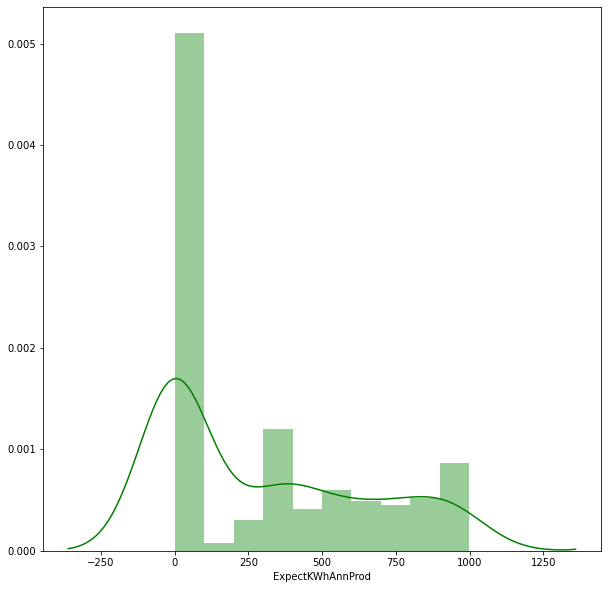

In [20]:
sql_statement="""SELECT * FROM ProjectProd"""
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query(sql_statement, conn)
print(df['ExpectKWhAnnProd'].describe())
plt.figure(figsize=(10, 10))
sns.distplot(pd.to_numeric(df['ExpectKWhAnnProd'],errors='coerce'), color='g', bins=10, hist_kws={'alpha': 0.4});

In [21]:
#from urllib.request import urlopen
#import json
#with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#    counties = json.load(response)
import plotly.express as px
import pandas as pd
import numpy as np
#Reading the csv file
df=pd.read_csv('solar.csv',sep=';')
print(df.columns)
#df.drop('State',inplace=True,axis=1)
df['Expected KWh Annual Production']=df['Expected KWh Annual Production'].replace(np.nan,0)
#pd.to_numeric(df['Expected KWh Annual Production'],errors='coerce'
df1 = pd.DataFrame(data=df['Expected KWh Annual Production'])
import pandas as pd
df_sample = pd.read_csv('Counties.csv',error_bad_lines=False)
df=pd.read_csv('solar.csv',sep=';')
#df=pd.read_csv('solar.csv')
df_county=df['County']
fips=[]
county=[]
ll=[]
for ele in df_sample.iterrows():
    ll.append((ele[1][0],ele[1][1]))
#print(ll)
i=0
ll2=[]
ll3=[]
flag=0
df[pd.isnull(df['County'])]
for ele in df['County']:
    flag=0
    for i in range(len(ll)):
        #ele=str(ele)
        if type(ele)==float:
            ele=str(ele)
            ele=ele.strip()
        ele=ele.replace('.','')
        if ele==ll[i][1]:
            #print(type(ll[i][1]))
            ll2.append(ll[i][0])
            flag=1
    if flag==0:
        ll2.append('36123')
df11=pd.DataFrame()
df11['fips']=ll2
df11['solarprod']=df['Expected KWh Annual Production']
print(df11.head())

C:\Users\ayushga\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning:

Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.



Index(['Reporting Period', 'Project Number', 'Legacy Project Number', 'City',
       'County', 'State', 'Zip Code', 'Sector', 'Program Type', 'Solicitation',
       'Electric Utility', 'Purchase Type', 'Date Application Received',
       'Date Completed', 'Project Status', 'Contractor',
       'Primary Inverter Manufacturer', 'Primary Inverter Model Number',
       'Total Inverter Quantity', 'Primary PV Module Manufacturer',
       'PV Module Model Number', 'Total PV Module Quantity', 'Project Cost',
       '$Incentive', 'Total Nameplate kW DC', 'Expected KWh Annual Production',
       'Remote Net Metering', 'Affordable Solar',
       'Community Distributed Generation',
       'Green Jobs Green New York Participant', 'Location 1'],
      dtype='object')
    fips   solarprod
0  36103    2,535.00
1  36103   12,208.00
2  36103   14,849.00
3  36091  576,483.00
4  36109    2,428.00


In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
import plotly.express as px
print(df11.head())
fig = px.choropleth(df11, geojson=counties, locations='fips', color='solarprod',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           scope="usa",
                           labels={'solarprod':'Annual Solar Production'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()